In [1]:
import sparsedm
import numpy as np
import matplotlib.pyplot as plt
import circuit
%matplotlib inline

In [2]:
qubit_names = ["D1", "A1", "D2", "A2", "D3"]

In [3]:
t_meas = 300
t_rest = 1000
t_gate = 40

t1 = 25000
t2 = 16000

readout_error = 0#0.0015

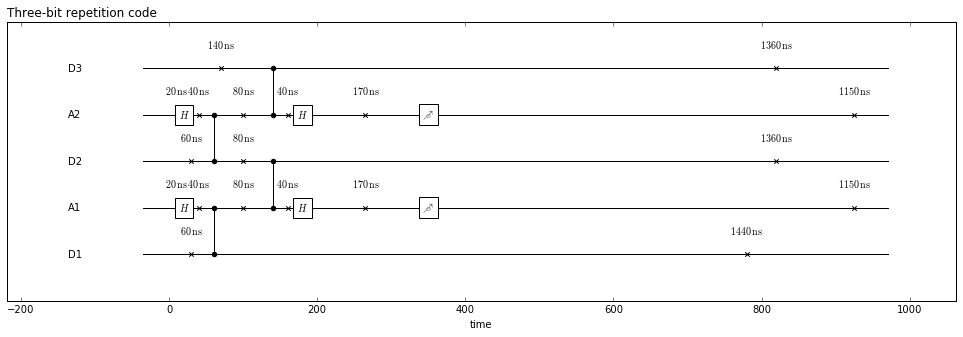

In [7]:
c = circuit.Circuit("Three-bit repetition code")

for qb in qubit_names:
    c.add_qubit(qb, t1, t2)
    
c.add_hadamard("A1", time=0.5*t_gate)
c.add_hadamard("A2", time=0.5*t_gate)

c.add_cphase("A1", "D1", time=1.5*t_gate)
c.add_cphase("A2", "D2", time=1.5*t_gate)

c.add_cphase("A1", "D2", time=3.5*t_gate)
c.add_cphase("A2", "D3", time=3.5*t_gate)

c.add_hadamard("A1", time=4.5*t_gate)
c.add_hadamard("A2", time=4.5*t_gate)

m1 = circuit.Measurement("A1", time=5*t_gate+0.5*t_meas, sampler=None)
c.add_gate(m1)
m2 = circuit.Measurement("A2", time=5*t_gate+0.5*t_meas, sampler=None)
c.add_gate(m2)

c.add_waiting_gates(tmin=0, tmax=5*t_gate+t_meas+t_rest)

plt.figure(figsize=(17,5))


c.plot()
c.order()


repetition_code_round = c

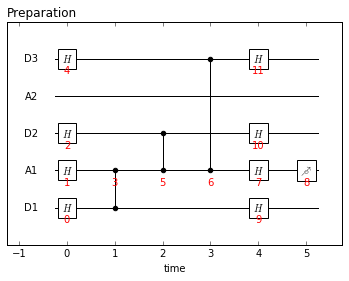

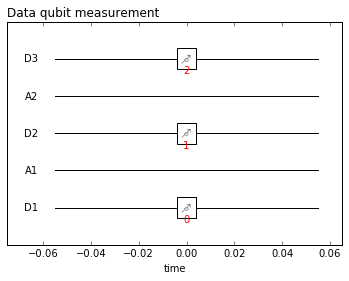

In [5]:
c = circuit.Circuit("Preparation")

for qb in qubit_names:
    c.add_qubit(qb, t1, t2)

c.add_hadamard("D1", 0)
c.add_hadamard("D2", 0)
c.add_hadamard("D3", 0)
c.add_hadamard("A1", 0)

c.add_cphase("A1", "D1", 1)
c.add_cphase("A1", "D2", 2)
c.add_cphase("A1", "D3", 3)

c.add_hadamard("A1", 4)
c.add_hadamard("D1", 4)
c.add_hadamard("D2", 4)
c.add_hadamard("D3", 4)

c.add_measurement("A1", time=5, sampler=None)

c.order()
c.plot()

preparation_circuit = c

plt.figure()

c = circuit.Circuit("Data qubit measurement")

for qb in qubit_names:
    c.add_qubit(qb, t1, t2)


c.add_measurement("D1", 0, sampler=None)
c.add_measurement("D2", 0, sampler=None)
c.add_measurement("D3", 0, sampler=None)


c.order()
c.plot()

final_meas_circuit = c


In [9]:
import qec
import qec.circuit_characterization.error_model.unsymmetrised_decay as err_model
import qec.circuit_characterization.circuit_model.three_qbit_realistic_kraus as circuit_model
import qec.error_correction.correction_method.asym_de_rep as correction

In [10]:
tom_error = err_model.Error(T1=t1, ro=readout_error, t_rest=t_rest, Tphi=t2) 
tom_circuit = circuit_model.Circuit(tom_error, t_rest, t_gate, t_meas)

tom_circuit.m2 = 1
tom_circuit.m4 = 1 # fudge hard!

In [11]:
tom_decoder = correction.Correction(tom_circuit)

In [21]:
tom_decoder.reset()
sdm = sparsedm.SparseDM(qubit_names)

for bit in sdm.classical:
    sdm.classical[bit] = 1
    
preparation_circuit.apply_to(sdm)
sdm.renormalize()

#print(sdm.peak_multiple_measurements(["D1", "D2", "D3"]))
    
for i in range(100):
    repetition_code_round.apply_to(sdm)
    syndrome = [m1.measurements[-1], m2.measurements[-1]]
    tom_decoder.update(syndrome)
    print(syndrome, tom_decoder.result())
    
    
final_meas_circuit.apply_to(sdm)
print("final measurement:", [m.measurements[0] for m in final_meas_circuit.gates])



[0, 1] [1, 0, 0]
[0, 1] [0, 0, 0]
[0, 1] [0, 0, 0]
[0, 1] [0, 0, 0]
[0, 0] [0, 0, 1]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[0, 0] [0, 0, 0]
[1, 0] [1, 0, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 0] [1, 1, 0]
[1, 1] [1, 1, 0]
[1, 1] [1, 1, 1]
[1, 1] [1, 1, 1]
[1, 1] [1, 1, 1]
[1, 0] [1, 1, 0]
[1, 0] [1, 1, 1]
[1, 0] [1, 1, 1]
[0, 0] [0, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 1]
[0, 0] [1, 1, 

In [ ]:
sdm = sparsedm.SparseDM(qubit_names)

preparation_circuit.apply_to(sdm)
#sdm.renormalize()
final_meas_circuit.apply_to(sdm)

result = [m.measurements[-1] for m in final_meas_circuit.gates if m.is_measurement]

print(result)
print(sdm.trace())
    

In [ ]:
sdm.trace()

In [ ]:
m2.measurements

In [ ]:
m2.measurements